In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tqdm import tqdm
from warnings import filterwarnings

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image

In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [4]:
X_train = []
y_train = []
drive_path = '/content/drive/MyDrive/Ai Intern/Data'
image_size = 150
for i in labels:
    folderPath = os.path.join(drive_path, 'Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join(drive_path, 'Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:57<00:00,  1.28it/s]


In [5]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)


In [6]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)


In [7]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [8]:
def Show(model):
  heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

In [9]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))


16705208/16705208 [==============================] - 2s 0us/step


In [10]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(1024,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.4)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [12]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [16]:
tensorboard = TensorBoard(log_dir='logs/effnet')

checkpoint = ModelCheckpoint("logs/efficientnetB0", monitor="val_accuracy",
                             save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [17]:
history = model.fit(X_train,y_train,validation_split = 0.15, epochs = 10, verbose = 1,
                    batch_size = 16, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/10
156/156 [==============================] - ETA: 0s - loss: 0.2763 - accuracy: 0.9219
Epoch 1: val_accuracy improved from -inf to 0.85374, saving model to logs/efficientnetB0
156/156 [==============================] - 45s 281ms/step - loss: 0.2763 - accuracy: 0.9219 - val_loss: 0.4520 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 2/10
156/156 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9391
Epoch 2: val_accuracy did not improve from 0.85374
156/156 [==============================] - 12s 77ms/step - loss: 0.1797 - accuracy: 0.9391 - val_loss: 1.2276 - val_accuracy: 0.6122 - lr: 0.0010
Epoch 3/10
156/156 [==============================] - ETA: 0s - loss: 0.1002 - accuracy: 0.9639
Epoch 3: val_accuracy improved from 0.85374 to 0.91837, saving model to logs/efficientnetB0
156/156 [==============================] - 44s 281ms/step - loss: 0.1002 - accuracy: 0.9639 - val_loss: 0.2784 - val_accuracy: 0.9184 - lr: 0.0010
Epoch 4/10
156/156 [====================

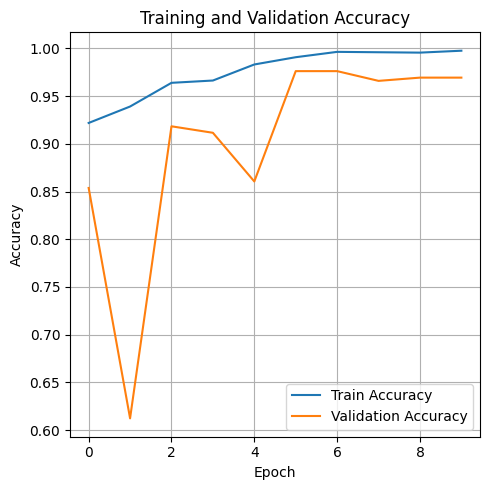

In [18]:
plt.figure(figsize = (5,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

11/11 [==============================] - 0s 32ms/step


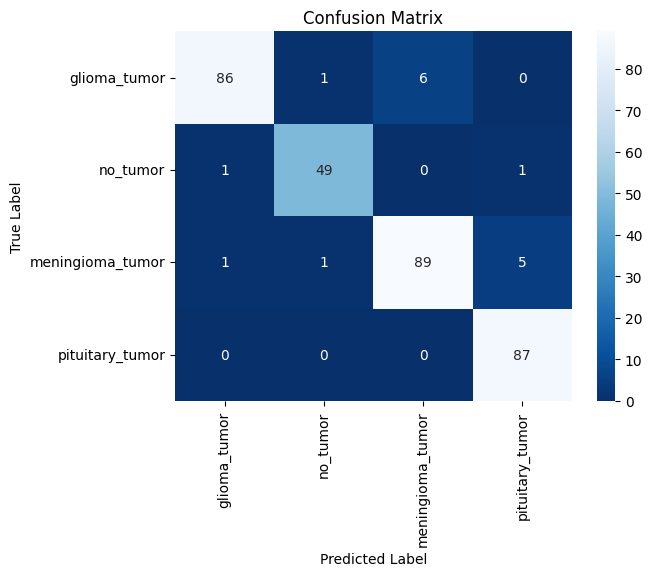

In [21]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1)


Show(model)

In [22]:
print(classification_report(y_true_test,y_pred_test))


              precision    recall  f1-score   support

           0       0.98      0.92      0.95        93
           1       0.96      0.96      0.96        51
           2       0.94      0.93      0.93        96
           3       0.94      1.00      0.97        87

    accuracy                           0.95       327
   macro avg       0.95      0.95      0.95       327
weighted avg       0.95      0.95      0.95       327



1/1 [==============================] - 1s 1s/step
Predicted label: meningioma_tumor 
Actual label: meningioma_tumor 
Confidence: 100.00%



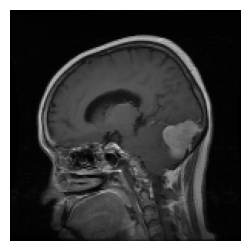

In [23]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model.predict(random_img.reshape(1, 150, 150, 3))

predicted_class = np.argmax(predictions)
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()


In [25]:
resnet = tf.keras.applications.ResNet101(weights='imagenet', include_top=False,
                                         input_shape=(image_size, image_size, 3))


model2 = resnet.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(rate=0.5)(model2)
model2 = tf.keras.layers.Dense(4,activation='softmax')(model2)
model2 = tf.keras.models.Model(inputs=resnet.input, outputs = model2)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

171446536/171446536 [==============================] - 8s 0us/step


In [26]:
model2.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [27]:
tensorboard = TensorBoard(log_dir='logs/resnet')


checkpoint = ModelCheckpoint("logs/resnet", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [28]:
history = model2.fit(X_train,y_train,validation_split=0.2, epochs =12, verbose=1, batch_size=16,callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
147/147 [==============================] - ETA: 0s - loss: 1.0617 - accuracy: 0.6224
Epoch 1: val_accuracy improved from -inf to 0.36735, saving model to logs/resnet
147/147 [==============================] - 156s 569ms/step - loss: 1.0617 - accuracy: 0.6224 - val_loss: 50.3497 - val_accuracy: 0.3673 - lr: 0.0010
Epoch 2/12
147/147 [==============================] - ETA: 0s - loss: 0.6741 - accuracy: 0.7412
Epoch 2: val_accuracy did not improve from 0.36735
147/147 [==============================] - 28s 188ms/step - loss: 0.6741 - accuracy: 0.7412 - val_loss: 2.9868 - val_accuracy: 0.3520 - lr: 0.0010
Epoch 3/12
147/147 [==============================] - ETA: 0s - loss: 0.4785 - accuracy: 0.8306
Epoch 3: val_accuracy improved from 0.36735 to 0.61905, saving model to logs/resnet
147/147 [==============================] - 78s 533ms/step - loss: 0.4785 - accuracy: 0.8306 - val_loss: 0.9665 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 4/12
147/147 [==============================] -

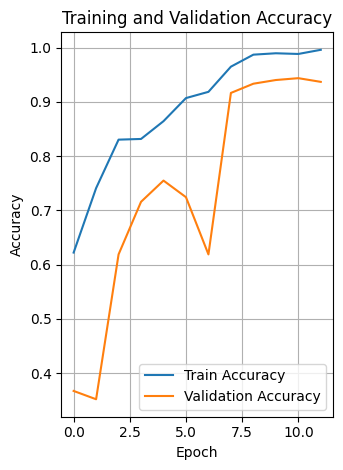

In [29]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

11/11 [==============================] - 1s 85ms/step


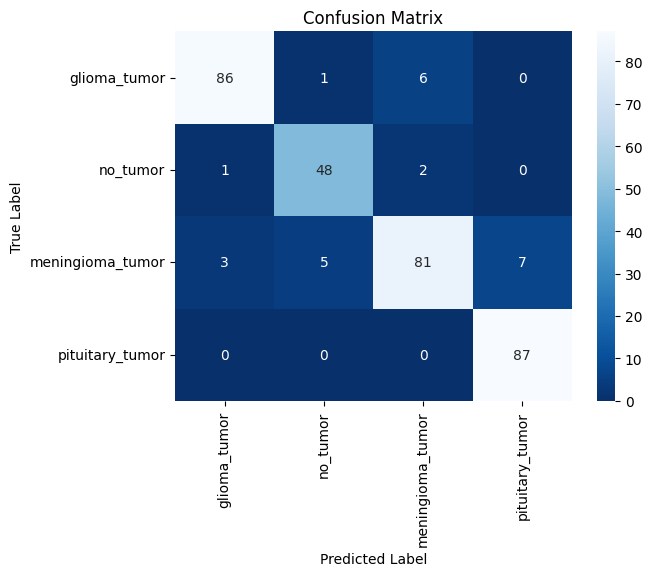

In [31]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model2.predict(X_test), axis=1)
Show(model2)

In [32]:
print(classification_report(y_true_test,y_pred_test))


              precision    recall  f1-score   support

           0       0.96      0.92      0.94        93
           1       0.89      0.94      0.91        51
           2       0.91      0.84      0.88        96
           3       0.93      1.00      0.96        87

    accuracy                           0.92       327
   macro avg       0.92      0.93      0.92       327
weighted avg       0.92      0.92      0.92       327



1/1 [==============================] - 1s 765ms/step
Predicted label: meningioma_tumor 
Actual label: meningioma_tumor 
Confidence: 99.03%



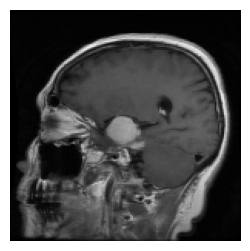

In [33]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model2.predict(random_img.reshape(1, 150, 150, 3))


predicted_class = np.argmax(predictions)
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

In [41]:
xception = tf.keras.applications.Xception(weights='imagenet', include_top=False,
                                          input_shape=(image_size, image_size, 3))
model3 = xception.output
model3 = tf.keras.layers.GlobalAveragePooling2D()(model3)
model3 = tf.keras.layers.Dense(1024,activation='relu')(model3)
model3 = tf.keras.layers.Dropout(rate=0.5)(model3)
model3 = tf.keras.layers.Dense(4,activation='softmax')(model3)
model3 = tf.keras.models.Model(inputs=xception.input, outputs = model3)

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_5[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]'

In [43]:
tensorboard = TensorBoard(log_dir='logs/xception')

checkpoint = ModelCheckpoint("logs/xception", monitor="val_accuracy",save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,min_delta=0.0001, verbose=1)

In [45]:
history = model3.fit(X_train,y_train,validation_split=0.2, epochs =14, verbose=1, batch_size=32,callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/14
74/74 [==============================] - ETA: 0s - loss: 0.3788 - accuracy: 0.8774
Epoch 1: val_accuracy improved from 0.49830 to 0.63435, saving model to logs/xeptcion
74/74 [==============================] - 41s 554ms/step - loss: 0.3788 - accuracy: 0.8774 - val_loss: 2.0045 - val_accuracy: 0.6344 - lr: 0.0010
Epoch 2/14
74/74 [==============================] - ETA: 0s - loss: 0.2356 - accuracy: 0.9293
Epoch 2: val_accuracy improved from 0.63435 to 0.88605, saving model to logs/xeptcion
74/74 [==============================] - 36s 492ms/step - loss: 0.2356 - accuracy: 0.9293 - val_loss: 0.6242 - val_accuracy: 0.8861 - lr: 0.0010
Epoch 3/14
74/74 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.9553
Epoch 3: val_accuracy did not improve from 0.88605
74/74 [==============================] - 17s 234ms/step - loss: 0.1524 - accuracy: 0.9553 - val_loss: 0.9363 - val_accuracy: 0.8827 - lr: 0.0010
Epoch 4/14
74/74 [==============================] - ETA: 0s 

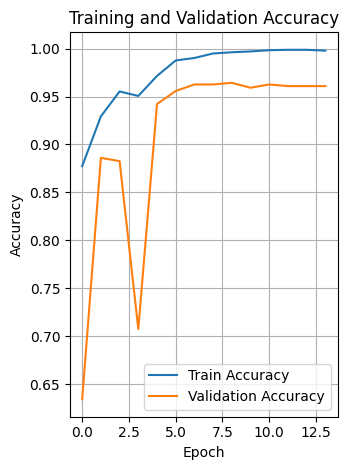

In [46]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

11/11 [==============================] - 1s 55ms/step


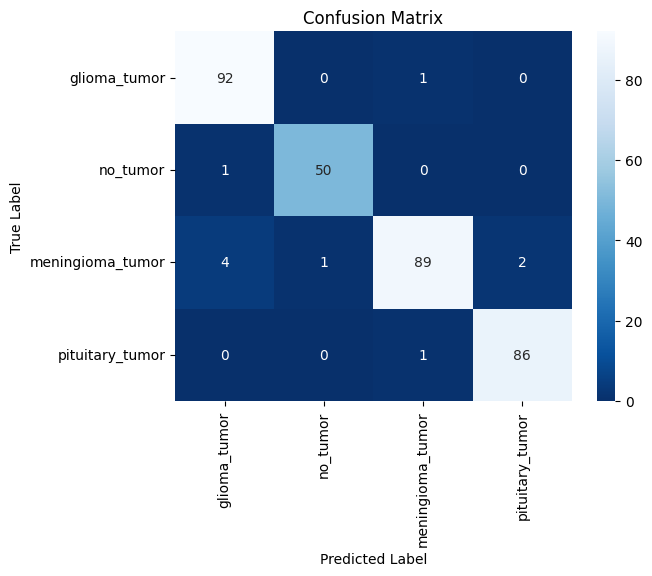

In [47]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model3.predict(X_test), axis=1)

Show(model3)

In [48]:
print(classification_report(y_true_test,y_pred_test))


              precision    recall  f1-score   support

           0       0.95      0.99      0.97        93
           1       0.98      0.98      0.98        51
           2       0.98      0.93      0.95        96
           3       0.98      0.99      0.98        87

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



1/1 [==============================] - 1s 995ms/step
Predicted label: glioma_tumor 
Actual label: glioma_tumor 
Confidence: 99.98%



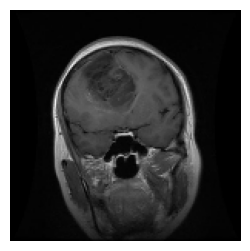

In [57]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model3.predict(random_img.reshape(1, 150, 150, 3))

predicted_class = np.argmax(predictions)
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

In [50]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in vgg16.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [51]:
model4 = vgg16.output
model4 = tf.keras.layers.GlobalAveragePooling2D()(model4)
model4 = tf.keras.layers.Dense(1024, activation='relu')(model4)
model4 = tf.keras.layers.Dropout(rate=0.5)(model4)
model4 = tf.keras.layers.Dense(4, activation='softmax')(model4)
model4 = tf.keras.models.Model(inputs=vgg16.input, outputs=model4)

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs/vgg16')

checkpoint = tf.keras.callbacks.ModelCheckpoint("logs/vgg16", monitor="val_accuracy", save_best_only=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, min_delta=0.0001, verbose=1)

In [53]:
history = model4.fit(X_train, y_train, validation_split=0.2, epochs=12, verbose=1, batch_size=32, callbacks=[tensorboard, checkpoint, reduce_lr])


Epoch 1/12
74/74 [==============================] - ETA: 0s - loss: 2.6034 - accuracy: 0.6428
Epoch 1: val_accuracy improved from -inf to 0.80952, saving model to logs/vgg16
74/74 [==============================] - 17s 161ms/step - loss: 2.6034 - accuracy: 0.6428 - val_loss: 0.8440 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 2/12
73/74 [============================>.] - ETA: 0s - loss: 0.8473 - accuracy: 0.7924
Epoch 2: val_accuracy improved from 0.80952 to 0.82143, saving model to logs/vgg16
74/74 [==============================] - 10s 142ms/step - loss: 0.8445 - accuracy: 0.7927 - val_loss: 0.5952 - val_accuracy: 0.8214 - lr: 0.0010
Epoch 3/12
73/74 [============================>.] - ETA: 0s - loss: 0.4756 - accuracy: 0.8395
Epoch 3: val_accuracy improved from 0.82143 to 0.86565, saving model to logs/vgg16
74/74 [==============================] - 8s 105ms/step - loss: 0.4741 - accuracy: 0.8399 - val_loss: 0.4722 - val_accuracy: 0.8656 - lr: 0.0010
Epoch 4/12
73/74 [====================

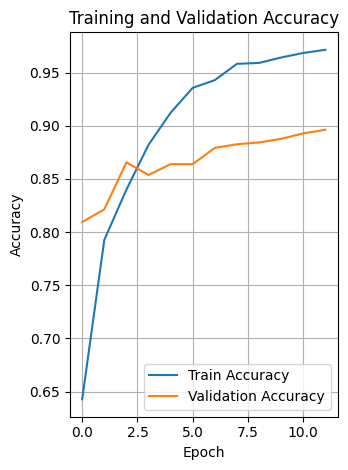

In [54]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

11/11 [==============================] - 1s 63ms/step


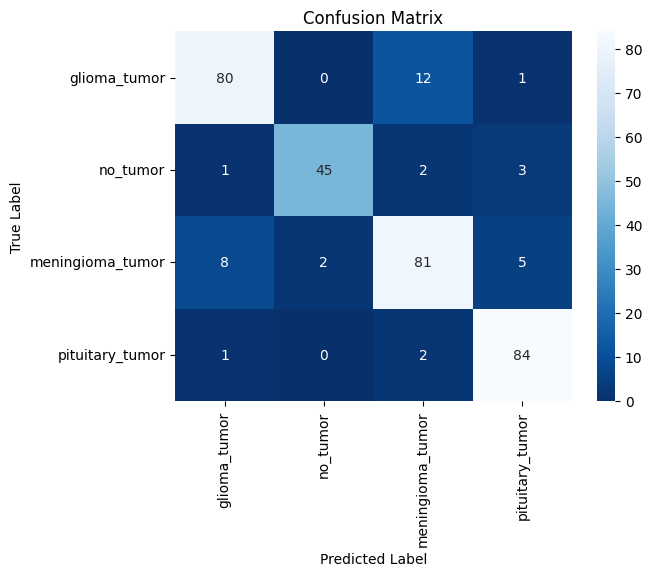

In [55]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model4.predict(X_test), axis=1)

Show(model4)

In [56]:
print(classification_report(y_true_test,y_pred_test))


              precision    recall  f1-score   support

           0       0.89      0.86      0.87        93
           1       0.96      0.88      0.92        51
           2       0.84      0.84      0.84        96
           3       0.90      0.97      0.93        87

    accuracy                           0.89       327
   macro avg       0.90      0.89      0.89       327
weighted avg       0.89      0.89      0.89       327



1/1 [==============================] - 1s 878ms/step
Predicted label: pituitary_tumor 
Actual label: pituitary_tumor 
Confidence: 98.81%



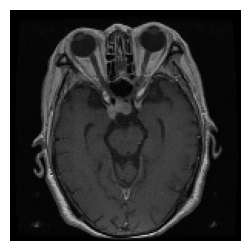

In [58]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model4.predict(random_img.reshape(1, 150, 150, 3))

predicted_class = np.argmax(predictions)
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()

## My Model

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model5 = Sequential()

model5.add(Conv2D(64, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))

model5.add(MaxPooling2D((2, 2)))

model5.add(Conv2D(64, (3, 3), activation='relu'))
model5.add(MaxPooling2D((2, 2)))

model5.add(Flatten())

model5.add(Dense(256, activation='relu'))
model5.add(Dropout(0.5))

model5.add(Dense(4, activation='softmax'))

model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model5.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               2

In [61]:
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs/my_model')

checkpoint = tf.keras.callbacks.ModelCheckpoint("logs/my_model", monitor="val_accuracy", save_best_only=True, verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, min_delta=0.0001, verbose=1)

In [64]:
history = model5.fit(X_train, y_train, validation_split=0.15, epochs=12, batch_size=8, verbose=1, callbacks=[tensorboard, checkpoint, reduce_lr])

Epoch 1/12
312/312 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9964
Epoch 1: val_accuracy improved from 0.87755 to 0.91156, saving model to my_model
312/312 [==============================] - 13s 41ms/step - loss: 0.0153 - accuracy: 0.9964 - val_loss: 0.4377 - val_accuracy: 0.9116 - lr: 1.0000e-06
Epoch 2/12
312/312 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9952
Epoch 2: val_accuracy did not improve from 0.91156
312/312 [==============================] - 5s 16ms/step - loss: 0.0181 - accuracy: 0.9952 - val_loss: 0.4399 - val_accuracy: 0.9093 - lr: 1.0000e-06
Epoch 3/12
309/312 [============================>.] - ETA: 0s - loss: 0.0177 - accuracy: 0.9956
Epoch 3: val_accuracy did not improve from 0.91156

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
312/312 [==============================] - 5s 17ms/step - loss: 0.0176 - accuracy: 0.9956 - val_loss: 0.4399 - val_accuracy: 0.9093 - lr: 1.0000e-06
Epo

11/11 [==============================] - 0s 13ms/step


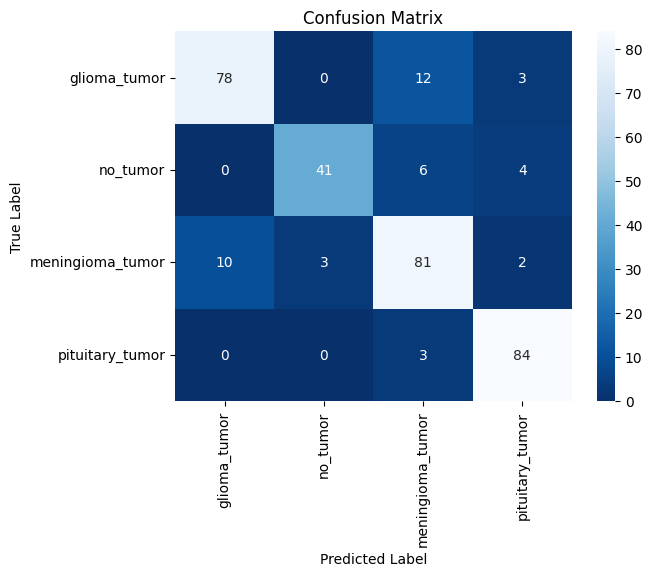

In [66]:
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model5.predict(X_test), axis=1)
Show(model5)

In [67]:
print(classification_report(y_true_test,y_pred_test))


              precision    recall  f1-score   support

           0       0.89      0.84      0.86        93
           1       0.93      0.80      0.86        51
           2       0.79      0.84      0.82        96
           3       0.90      0.97      0.93        87

    accuracy                           0.87       327
   macro avg       0.88      0.86      0.87       327
weighted avg       0.87      0.87      0.87       327



1/1 [==============================] - 0s 21ms/step
Predicted label: no_tumor 
Actual label: no_tumor 
Confidence: 99.98%



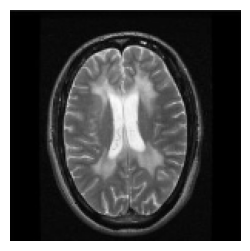

In [68]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]
predictions = model5.predict(random_img.reshape(1, 150, 150, 3))

predicted_class = np.argmax(predictions)
predicted_label = labels[predicted_class]
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]
actual_class = np.argmax(actual_index)
actual_label = labels[actual_class]

print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')
plt.show()